# Vanilla GAN

This project consist in the implementation of a simple GAN (Generator + Discriminator) using the MNIST Dataset and Pytorch framework.
The implementation is based on Ian Godfellow's basic GAN implementation. It uses the same loss based on the logarithm (ln(x))

A [utilities package](../utils/) is implemented before and alongside the notebook in order to provide basic functionalities regarding building tensors, logging training results, building the networks backbones and providing basic transforms for processing. 

In [56]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from utils.logger import Logger
from utils.networks import DiscriminatorNet, GeneratorNet
from utils.transforms import images_to_vectors, vectors_to_images, noise
from utils.tensors import ones_target, zeros_target

## Downloading Dataset

The dataset is downloaded from torchvision datasets package, downloading the training set in the dataset folder.

The dataset is preprocessed, using image normalization transforms (pixel values in [-1,1] interval), and flattening the image vector

A torch data_loader with batch_size 100 is used as data manager

In [42]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((.5),(.5))
        ]
    )
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, transform=compose, train=True, download=True)

data = mnist_data()

data_loader = torch.utils.data.DataLoader(data, batch_size=100,shuffle=True)
num_batches = len(data_loader)

## Models

The model objects of both the discriminator and generator are instantiaded bellow, using the backbone implementation contained in [networks utilities package](../utils/networks.py)

Both backbones consist in simple graphs containing combinations of batch normalization, dropouts and fully connected layers. Also both models are designed in order to receive and generate dimensionally matching tensors (discriminator with a 784 [or 28x28] image input, and generetor outputing a 784 tensor)

In [43]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

## Optimizers
In both cases an Adam optimizer is used with a small learning rate of 0.0002

In [44]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

In [45]:
d_optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    maximize: False
    weight_decay: 0
)>

## Loss

A Binary Cross Entropy Loss is chosen since it resembles the log-loss of both the Generator and Discriminator

In [46]:
loss = nn.BCELoss()

## Train Routines

Below are the training routines for both the discriminator and generator, alongside the full GAN model training

The resulting images from the generator (random input noise) and the model errors are displayed and updated every 100 batches

In [47]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad() # <- reset gradients

    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake


In [48]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    optimizer.zero_grad() # <- reset gradients

    prediction = discriminator(fake_data)

    error = loss(prediction, ones_target(N))
    error.backward()

    optimizer.step()

    return error
    

In [49]:
num_test_samples = 16
test_noise = noise(num_test_samples)

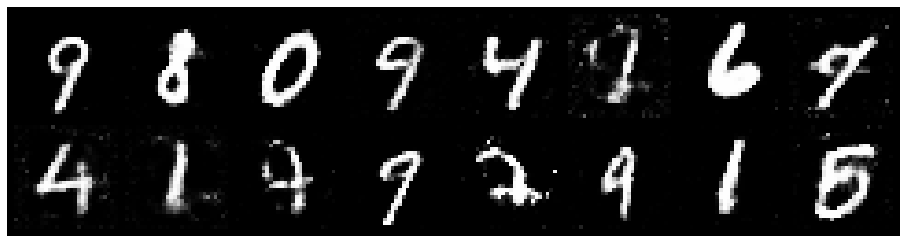

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.2477, Generator Loss: 0.9591
D(x): 0.5760, D(G(z)): 0.4537


In [50]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of training epochs
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        N = real_batch.size(0)

        real_data = Variable(images_to_vectors(real_batch))
        fake_data = generator(noise(N)).detach()

        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        fake_data = generator(noise(N))

        g_error = train_generator(g_optimizer, fake_data)

        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        if(n_batch) % 100 == 0:
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            logger.log_images(
                test_images, num_test_samples,
                epoch, n_batch, num_batches, format=None
            )

            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [51]:
# Saves the trained model
logger.save_models(epoch=200, discriminator=discriminator, generator=generator)

## Loading Models and Exporting to ONNX

In [52]:
from utils.onnx_utils import torch_to_onnx, load_models
import sys
import logging

logging.basicConfig(format='(%(process)s) [%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout, encoding='utf-8')
log = logging.getLogger('ExportLog')

discriminator, generator = load_models(root_dir='data/models/VGAN/MNIST', epoch=200, logger=log)
torch_to_onnx(root_dir='data/models/VGAN/MNIST', discriminator= discriminator, generator=generator, epoch=200, logger=log)

(58493) [INFO] Loading pretrained discriminator data/models/VGAN/MNIST/D_epoch_200.pt
(58493) [INFO] Loading pretrained generator data/models/VGAN/MNIST/G_epoch_200.pt
(58493) [INFO] Exporting Discriminator to data/models/VGAN/MNIST/D_epoch_200_onnx.onnx
(58493) [INFO] Exported Discriminator to data/models/VGAN/MNIST/D_epoch_200_onnx.onnx
(58493) [INFO] Exporting Generator to data/models/VGAN/MNIST/G_epoch_200_onnx.onnx
(58493) [INFO] Exported Generator to data/models/VGAN/MNIST/G_epoch_200_onnx.onnx


## Using ONNX for Inference

Using ONNX converted models for inference, and measuring the inference time.

Displaying generator result from random noise with matplotlib

(58493) [INFO] Inference time: 0.000852s
(58493) [INFO] Final Output Shape: (8, 28, 28, 1)


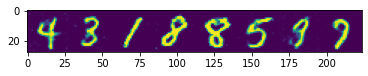

In [120]:
import onnxruntime as ort
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

opts = ort.SessionOptions()
opts.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
sess = ort.InferenceSession('data/models/VGAN/MNIST/G_epoch_200_onnx.onnx',sess_options=opts)
input_names = [i.name for i in sess.get_inputs()]
output_names = [o.name for o in sess.get_outputs()]

in_noise = noise(8).numpy()
#print(in_noise)

start = time.time()
output = sess.run(output_names, {i: in_noise for i in input_names})
end = time.time() - start

log.info(f"Inference time: {end:.6f}s")

# output = vectors_to_images(torch.from_numpy(output))
output = np.reshape(output, (-1,28,28))
output = output[...,np.newaxis]
output = cv2.normalize(output, None, 0, 1, cv2.NORM_MINMAX)
log.info(f"Final Output Shape: {output.shape}")
img = cv2.hconcat(output)
plt.imshow(img)
plt.show()

## Tensorboard Training Visualization

Using Tensorboard to plot SummaryWriter events.

In [126]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3134572), started 0:08:50 ago. (Use '!kill 3134572' to kill it.)